# Hierarcichal Modeling (Ignoring all boundedness problems)

We're modelling the following system. We have "available" to us the probability distributions of $Q$ and $\chi$ for each event we observed. We ask: What "population" distribution did these events get their values from?

Let's model that "population" distribution. It will have 4 parameters $\Lambda = \{\mu_Q, \sigma_Q, \mu_\chi, \sigma_\chi\}$ and probability distribution:

$$
p(\chi,Q | \Lambda) = \phi(Q|\mu_Q,\sigma_Q)\phi(\chi|\mu_\chi,\sigma_\chi)
$$

We then also set our prior estimate:

$$
\mu_Q \sim \mathcal{N}(0,1) \\
\sigma_Q \sim F\mathcal{N}(0,1) \\
\mu_\chi \sim \mathcal{N}(\chi_*,1) \\
\sigma_\chi \sim F\mathcal{N}(0,1) \\
$$

Our aim is to get posterior distributions over the $\Lambda$ parameters. 

$$
p(\Lambda | d) \propto \prod_{\textrm{e} \in \textrm{events}} \int p(Q,\chi | d_e)\frac{p(Q, \chi | \Lambda)}{p_{\emptyset}(Q,\chi)} dQ d\chi
$$ 

Now lets say we have a Gaussian Mixture Model (GMM) estimate of $p(Q,\chi | d_e)$. i.e.:

$$
p(Q,\chi | d_e) = \frac{1}{N_e}\sum_j w^e_j \phi(Q,\chi | \vec{\mu}_i, \mathbf{\sigma}_i)
$$

The GMM is completely defined by a list of vectors $\vec{\mu}_i$ and covariance matrices $\mathbf{\sigma}_i$

We can analytically write the final distribution since $p_{\emptyset} \propto 1$

$$
p(\Lambda | d) = \prod_{e} (\sum_j w^e_j \int \phi(Q,\chi | \vec{\mu}_i, \mathbf{\sigma}_i) \phi(Q,\chi|[\mu_Q,\mu_\chi],\sigma_\Lambda)dQd\chi)
$$

$$
p(\Lambda | d) = \prod_{e} (\sum_j w^e_j \phi(\mu_Q,\mu_\chi | \vec{\mu}_i, \mathbf{\sigma}_i + \sigma_\Lambda)) \int  \phi(Q,\chi | m_c, \sigma_c)dQd\chi)
$$

where $m_c$ and $\sigma_c$ are given in http://compbio.fmph.uniba.sk/vyuka/ml/old/2008/handouts/matrix-cookbook.pdf section 8.1.8. 

> We will assume the integral can be extended to infinite extent. Hence $\int\phi(Q,\chi | m_c, \sigma_c)dQd\chi = 1$

This means we can just write down the final distribution:

$$
p(\Lambda | d) = \prod_{e} (\sum_j w^e_j \phi(\mu_Q,\mu_\chi | \vec{\mu}_i, \mathbf{\sigma}_i + \sigma_\Lambda) )
$$

$$
logp(\Lambda|d) = \sum_e \textrm{logsumexp}([\log(w^e_j \phi(\mu_Q,\mu_\chi | \vec{\mu}_i, \mathbf{\sigma}_i + \sigma_\Lambda))\ \forall\ j])
$$

$$
logp(Q,\chi|d) = \sum_e \textrm{logsumexp}([\log(w^e_j) + \log(\phi(\mu_Q,\mu_\chi | \vec{\mu}_i, \mathbf{\sigma}_i + \sigma_\Lambda))\ \forall\ j])
$$

OR

$$
logp(Q,\chi|d) = \sum_e logp(GMM(\vec{\mu}_\Lambda | w = \{w^e_i\}, \mu = \{\vec{\mu}_i\}, \sigma = \{\mathbf{\sigma}_i + \sigma_\Lambda\}))
$$

We will do this in multiple steps. 

1. Use the posterior samples from each event to build a Gaussian Mixture Model (GMM) to approximate the actual posterior distribution.
2. Construct a potential with the logp given by the above equation. 





## Reconstruct the probability distributions in $Q,\chi$

First lets get the data from the events that look decent

In [1]:
import pymc as pm
import netCDF4 as nc
import numpy as np
import aesara
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt


events = ["GW150914","GW170104","GW170823","GW190519_153544",
          "GW190521","GW190521_074359","GW190706_222641",
          "GW190828_063405","GW200224_222234","GW200311_115853"]

ds = {}
points = {}

for event in events:
    fn = f"./ChargedResults/{event}/{event}-charged-posteriors.nc"
    a = nc.Dataset(fn)
    ds[event] = a
    points[event] = np.array([np.array(x) for x in zip(a['posterior']['chi'][:].flatten(),a['posterior']['Q_charge'][:].flatten())])

events_that_look_alright = ['GW150914','GW190519_153544',
                            'GW190521','GW190521_074359',
                            'GW190706_222641','GW200224_222234']

n_events = len(events_that_look_alright)

points_good = {k:v for k,v in points.items() if k in events_that_look_alright}

In [41]:
ds['GW150914']['posterior'].variables

{'chain': <class 'netCDF4._netCDF4.Variable'>
 int64 chain(chain)
 path = /posterior
 unlimited dimensions: 
 current shape = (4,)
 filling on, default _FillValue of -9223372036854775806 used,
 'draw': <class 'netCDF4._netCDF4.Variable'>
 int64 draw(draw)
 path = /posterior
 unlimited dimensions: 
 current shape = (2000,)
 filling on, default _FillValue of -9223372036854775806 used,
 'log_drift_unit_dim_0': <class 'netCDF4._netCDF4.Variable'>
 int64 log_drift_unit_dim_0(log_drift_unit_dim_0)
 path = /posterior
 unlimited dimensions: 
 current shape = (2,)
 filling on, default _FillValue of -9223372036854775806 used,
 'log_drift_unit': <class 'netCDF4._netCDF4.Variable'>
 float64 log_drift_unit(chain, draw, log_drift_unit_dim_0)
     _FillValue: nan
 path = /posterior
 unlimited dimensions: 
 current shape = (4, 2000, 2)
 filling on,
 'M': <class 'netCDF4._netCDF4.Variable'>
 float64 M(chain, draw)
     _FillValue: nan
 path = /posterior
 unlimited dimensions: 
 current shape = (4, 2000

then, some plotting convenience functions

In [24]:
def axplot_qchi(ax,points, gridsize=20, name="", **kwargs):
    ax.set_xlabel(r"$\chi$")
    ax.set_ylabel(r"$Q$")
    ax.hexbin(points[:,0],points[:,1],gridsize=gridsize, extent=(0,1,0,1), **kwargs)
    ax.plot(np.linspace(0,1,100), np.sqrt(1 - np.linspace(0,1,100)**2),c='b')
    ax.plot(np.linspace(0,1,100), 0.0*np.linspace(0,1,100),c='b')
    ax.set_title(name)
    return ax

from matplotlib import patches

def gaussian_ellipse(mean, cov, alpha=0.5, color='yellow'):
    x,y = mean
    v, w = np.linalg.eigh(cov)
    v = 2.0 * np.sqrt(5.991) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    el = patches.Ellipse(mean, v[0], v[1], 180.0 + angle, alpha=alpha, color=plt.get_cmap('viridis')(alpha))
    return el
    
def ax_plot_GMM_qchi(ax,gm, name="", uncorrelated=False):
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    ax.set_xlabel(r"$\chi$")
    ax.set_ylabel(r"$Q$")
    ax.set_facecolor([0.25,0.0,0.4])
    for i in range(n_gauss):
        if uncorrelated:
            cov = np.diag(gm.covariances_[i])
        else:
            cov = gm.covariances_[i]
        el = gaussian_ellipse(gm.means_[i], cov, 
                              alpha=gm.weights_[i]/gm.weights_.max())
        ax.add_patch(el)
    ax.plot(np.linspace(0,1,100), np.sqrt(1 - np.linspace(0,1,100)**2),c='b')
    ax.plot(np.linspace(0,1,100), 0.0*np.linspace(0,1,100),c='b')
    ax.set_title(name)
    return ax

/var/folders/x2/flf3cm9506vdxng0c9g04p440000gn/T/ipykernel_41766/427005604.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


<AxesSubplot:xlabel='$\\chi$', ylabel='$Q$'>

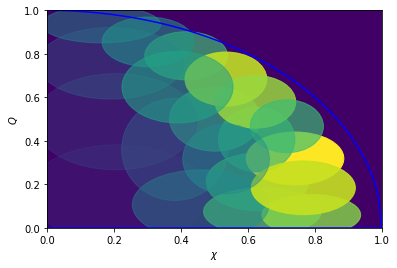

In [25]:
gm1 = GMMs_uncorr['GW150914']
fig, ax = plt.subplots(1)
ax_plot_GMM_qchi(ax,gm1, name="", uncorrelated=True)

### Fitting Gaussians to the data

In [34]:
from sklearn.mixture import GaussianMixture

n_gauss = 20
GMMs = {}
GMMs_uncorr = {}

for eventname, samples in points_good.items():
    GMMs[eventname] = GaussianMixture(n_components=n_gauss).fit(samples)
    GMMs_uncorr[eventname] = GaussianMixture(n_components=n_gauss, covariance_type='diag').fit(samples)

/var/folders/x2/flf3cm9506vdxng0c9g04p440000gn/T/ipykernel_41766/427005604.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


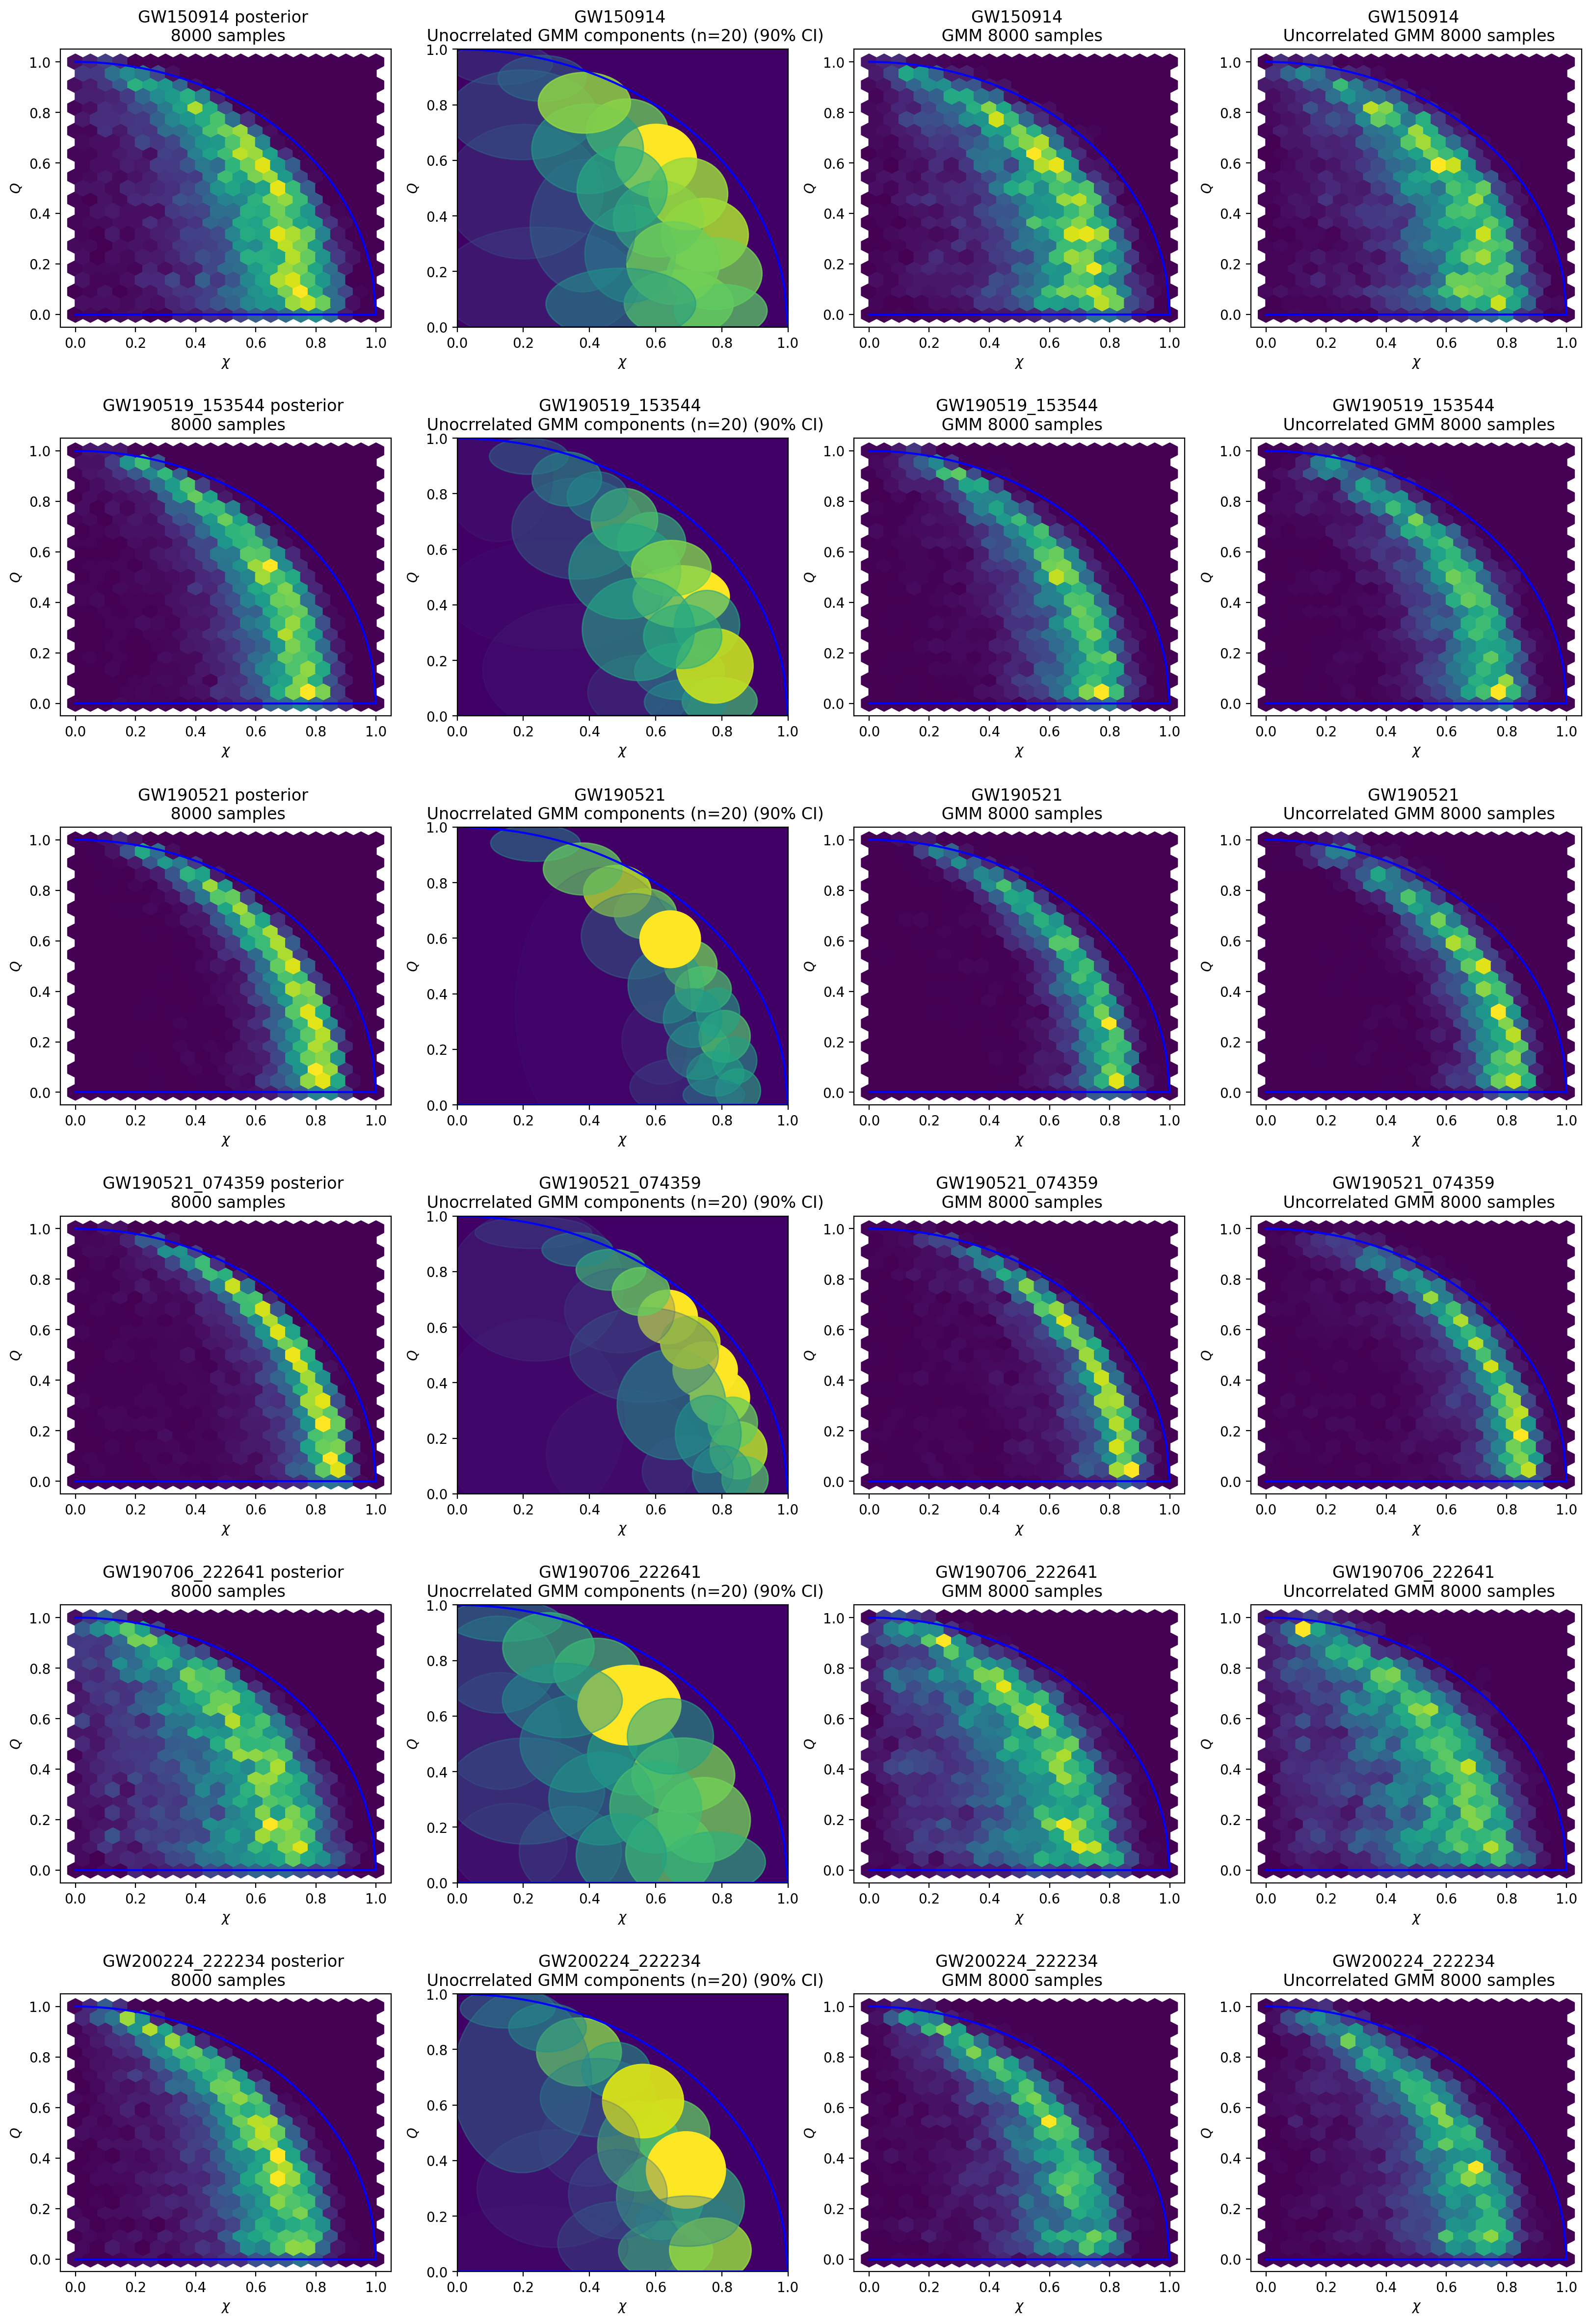

In [36]:
fig, axes = plt.subplots(nrows=len(GMMs), ncols=4, figsize = ((20,len(GMMs)*5)), dpi=200)

for i, eventname in enumerate(points_good.keys()):
    axes[i,0] = axplot_qchi(axes[i,0], points_good[eventname], name=f"{eventname} posterior \n 8000 samples")
    axes[i,1] = ax_plot_GMM_qchi(axes[i,1], GMMs_uncorr[eventname], name=f"{eventname} \n Unocrrelated GMM components (n=20) (90% CI)", uncorrelated=True)
    axes[i,2] = axplot_qchi(axes[i,2], GMMs[eventname].sample(8000)[0], name=f"{eventname} \n GMM 8000 samples")
    axes[i,3] = axplot_qchi(axes[i,3], GMMs_uncorr[eventname].sample(8000)[0], name=f"{eventname} \n Uncorrelated GMM 8000 samples")
    
plt.subplots_adjust(hspace=0.4)
plt.show()

As we can see above, just simple, non-bounded gaussians do a great job of reproducing the distribution. 

### New Idea

We know that 

$$
p(\Lambda | d) = p(\Lambda) \prod_{e} (\sum_j w^e_j \phi(\mu_Q,\mu_\chi | \vec{\mu}_i, \mathbf{\sigma}_i + \sigma_\Lambda) ) 
$$

This means that samples from the likelihood are just:

$$
L(d | \Lambda) \propto (\sum_j w^e_j \phi(\mu_Q,\mu_\chi | \vec{\mu}_i, \mathbf{\sigma}_i + \sigma_\Lambda) )  \\
$$


In [ ]:
eventnames = list(GMMs.keys())
GMM_means = np.array([GMMs[eventname].means_ for eventname in eventnames])
GMM_weights = np.array([GMMs[eventname].weights_ for eventname in eventnames])
GMM_covariances = np.array([GMMs[eventname].covariances_ for eventname in eventnames])

In [201]:
aesara

<module 'aesara' from '/Users/asadh/opt/anaconda3/envs/Hierarchical_Analysis/lib/python3.7/site-packages/aesara/__init__.py'>

In [205]:
def MakeGMM(gm, sigma_lambda):
    n = gm.n_components
    means = gm.means_
    covs = gm.covariances_
    weights = gm.weights_
    dists = [pm.MvNormal.dist(mu=means[i], cov=covs[i] + sigma_lambda) for i in range(n)]
    mix = pm.Mixture.dist(w=weights, comp_dists=dists)
    return mix




coordinates = {
        'events': range(n_events),
        'kernels': range(n_gauss),
        'chi_Q': range(2),
        'chi_Q_2': range(2) # For matrices, need a unique name
}

with pm.Model(coords=coordinates) as model:
    
    #sigma_chi = pm.HalfNormal('sigma_chi', sigma=1)
    #sigma_Q = pm.HalfNormal('sigma_Q', sigma=1)
    
    #mu_lambda = pm.MvNormal('mu_lambda', mu=[0.7, 0.0], cov=[[1, 0],[0, 1]])
    
    mu_lambda = pm.MvNormal('mu', mu=[0.7,0.0], cov=np.identity(2))
    Sigma_chol, _, _ = pm.LKJCholeskyCov('Sigma', eta=2, n=2, sd_dist=pm.HalfNormal.dist(sigma=1), compute_corr=True, store_in_trace=True)
    sigma_lambda = pm.Deterministic('Sigma_matrix', np.dot(Sigma_chol, Sigma_chol.T), dims=("chi_Q", "chi_Q_2"))
    
    #mix = MakeGMM(GMMs['GW150914'], sigma_lambda)
    #allS = pm.Potential('marginal_likelihood', pm.logp(mix, mu_lambda))
    
    trace2 = pm.sample(2000, tune=1000)

/Users/asadh/opt/anaconda3/envs/Hierarchical_Analysis/lib/python3.7/site-packages/pymc/aesaraf.py:1010: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  **kwargs,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, Sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6566, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'Sigma'}>,
        <AxesSubplot:title={'center':'Sigma'}>]], dtype=object)

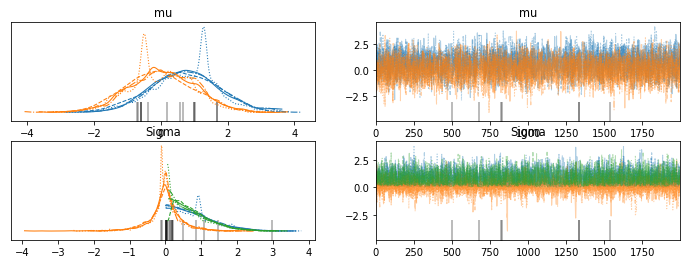

In [206]:
az.plot_trace(trace2, var_names=['mu', 'Sigma'])

In [84]:
coordinates = {
        'events': range(n_events),
        'kernels': range(n_gauss),
        'chi_Q': range(2),
        'chi_Q_2': range(2) # For matrices, need a unique name
}

eventnames = list(GMMs.keys())
GMM_means = np.array([GMMs[eventname].means_ for eventname in eventnames])
GMM_weights = np.array([GMMs[eventname].weights_ for eventname in eventnames])
GMM_covariances = np.array([GMMs[eventname].covariances_ for eventname in eventnames])



In [176]:
GMMs['GW150914'].means_.shape

(20, 2)

In [179]:
def lambda_log_likelihood(mu_ei, sigma_ei, weights_ei, mu_lambda, sigma_lambda):
    sigma_tot = sigma_ei + sigma_lambda
    dist = pm.MvNormal.dist(mu=mu_lambda, cov=sigma_tot)
    logp = pm.logp(dist, mu_ei) + at.log(weights_ei)
    return logp



with pm.Model(coords=coordinates) as model:
    ### Set up all the data
    kernel_means = [pm.ConstantData(f'mu_${i}', GMMs[eventname].means_, dims=("kernels", "chi_Q")) for i,eventname in enumerate(eventnames)]
    kernel_weights = [pm.ConstantData(f'w_${i}', GMMs[eventname].weights_, dims=("kernels")) for i,eventname in enumerate(eventnames)]
    kernel_covariances = [pm.ConstantData(f'sigma_${i}', GMMs[eventname].covariances_, dims=("kernels", "chi_Q", "chi_Q_2")) for i,eventname in enumerate(eventnames)]
    
    
    ### Priors
    mu_lambda = pm.MvNormal('mu', mu=[0.7,0.0], cov=np.identity(2))
    Sigma_chol, _, _ = pm.LKJCholeskyCov('Sigma', eta=2, n=2, sd_dist=pm.HalfNormal.dist(sigma=1), compute_corr=True, store_in_trace=True)
    sigma_lambda = pm.Deterministic('Sigma_matrix', np.dot(Sigma_chol, Sigma_chol.T), dims=("chi_Q", "chi_Q_2"))
    
    
    log_like = []
    for i,event in enumerate(eventnames):
        event_marg_loglikes, _ = aesara.map(lambda_log_likelihood, 
                                           sequences=[kernel_means[i], kernel_covariances[i], kernel_weights[i]],
                                           non_sequences=[mu_lambda, sigma_lambda])
        log_like.append(at.logsumexp(event_marg_loglikes))
    
    _ = pm.Potential('marginal_likelihood', at.sum(log_like))
    
    trace1 = pm.sample(2000)

/Users/asadh/opt/anaconda3/envs/Hierarchical_Analysis/lib/python3.7/site-packages/pymc/aesaraf.py:1010: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  **kwargs,
/Users/asadh/opt/anaconda3/envs/Hierarchical_Analysis/lib/python3.7/site-packages/pymc/aesaraf.py:1010: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dicti

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1374 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6437, but should be close to 0.8. Try to increase the number of tuning steps.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6894, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess

In [180]:
mu_trace = trace1.posterior['mu'].values

In [181]:
mu_samples = mu_trace.reshape((8000,2))

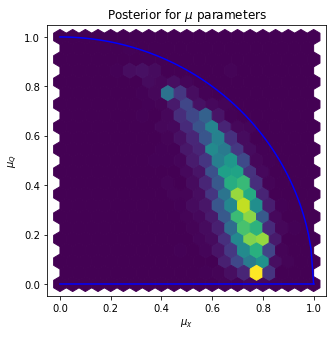

In [207]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.set_xlabel(r"$\mu_\chi$")
ax.set_ylabel(r"$\mu_Q$")
ax.hexbin(mu_samples[:,0],mu_samples[:,1],gridsize=20, extent=(0,1,0,1))
ax.plot(np.linspace(0,1,100), np.sqrt(1 - np.linspace(0,1,100)**2),c='b')
ax.plot(np.linspace(0,1,100), 0.0*np.linspace(0,1,100),c='b')
ax.set_title("Posterior for $\mu$ parameters")

plt.show()

/Users/asadh/opt/anaconda3/envs/Hierarchical_Analysis/lib/python3.7/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/asadh/opt/anaconda3/envs/Hierarchical_Analysis/lib/python3.7/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/asadh/opt/anaconda3/envs/Hierarchical_Analysis/lib/python3.7/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/asadh/opt/anaconda3/envs/Hierarchical_Analysis/lib/python3.7/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'Sigma_matrix'}>,
        <AxesSubplot:title={'center':'Sigma_matrix'}>]], dtype=object)

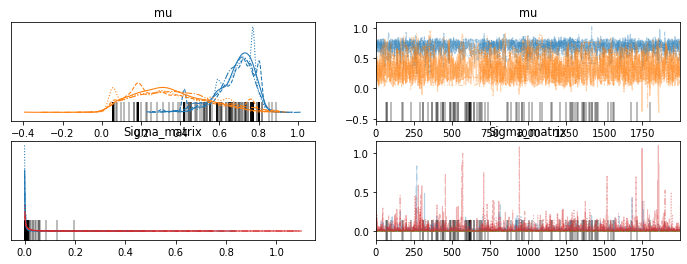

In [211]:
az.plot_trace(trace1,var_names=['mu','Sigma_matrix'])

In [190]:
trace1.sample_stats['diverging'].values

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [210]:
reshape = lambda x: x.reshape((x.shape[0]*x.shape[1],)+x.shape[2:])
A = np.array([np.linalg.eig(i)[0].max() for i in reshape(trace1.posterior['Sigma'].values)])

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

Inference data with groups:
	> posterior
	> sample_stats
	> constant_data

In [216]:
mu_var = model.basic_RVs[0]

In [220]:
mu_var

mu